In [1]:
## Импорт необходимых библиотек

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from datetime import datetime

In [ ]:
# pip install catboost

In [ ]:
## Весь бейзлайн кода был взят со страницы github Алгоритма Света: https://github.com/LanaLob/algorithm_sveta

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, precision_score, f1_score
import pickle

## Считывание файла тренировочной выборки и применение векторизации с помощью Tf-Idf

processed_data = pd.read_excel('preprocessed_data_2018.xlsx', index_col=0).set_index('ID')
cvect = TfidfVectorizer(min_df=0.05, ngram_range=(1, 2)).fit(processed_data['text_prep'])

In [8]:
## Названия всех столбцов таблицы

processed_data.columns

Index(['text', 'DV', 'IPV', 'text_prep'], dtype='object')

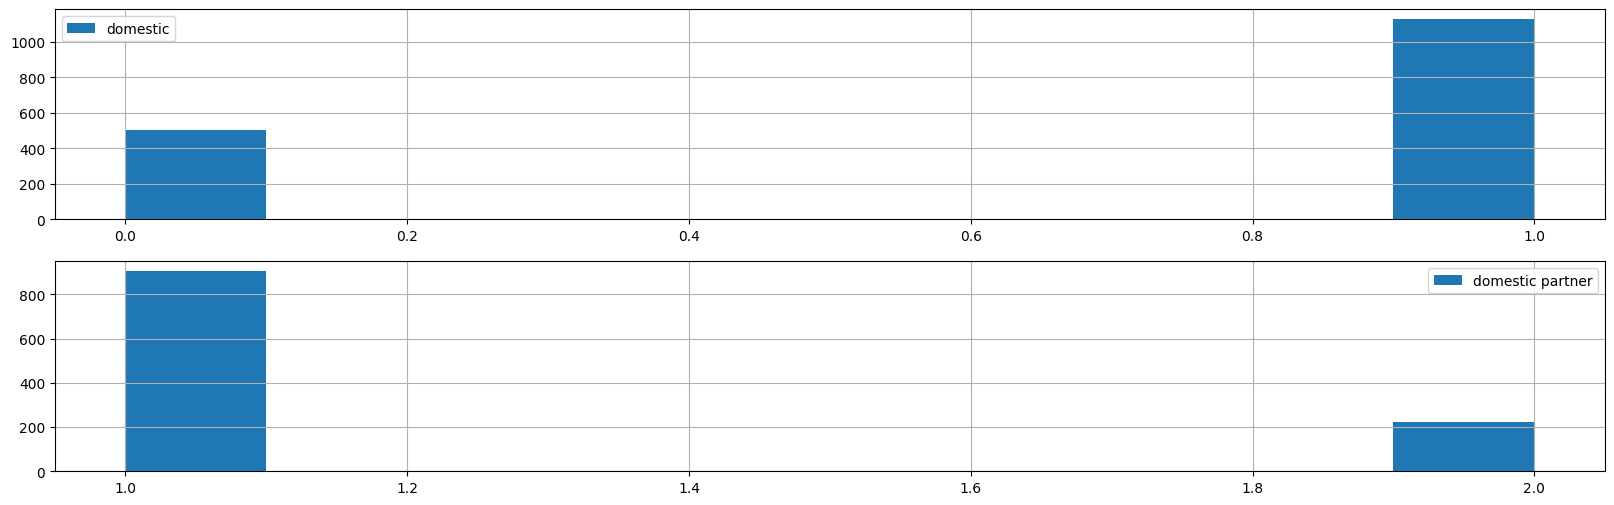

In [7]:
## Распределение числа наблюдений в обучающей в выборке

fig, axes = plt.subplots(2, 1, figsize=(20,6))

processed_data['DV'].hist(label='domestic', ax = axes[0])
processed_data['IPV'].hist(label='domestic partner', ax = axes[1])

axes[0].legend()
axes[1].legend()

In [11]:
## Формирование матрицы для последующего обучения модели

matrix = cvect.transform(processed_data['text_prep'])
td_matrix = pd.DataFrame(
    matrix.toarray(),
    index=processed_data.index,
    columns=cvect.get_feature_names_out()
    )
td_matrix.head()

,абонентский,абонентский номер,август,автомашина,автомобиль,агрессивный,агрессия,адвокат,адвокатский,адекватно,...,являться причина,являться родной,явный,ягодица,язык,якобы,январь,яремный,яремный вена,ящик
ID,,,,,,,,,,,,,,,,,,,,,
82060183bdf7472e85540c4370d3693c,0.0,0.0,0.00000,0.0,0.000000,0.008465,0.0,0.010552,0.0,0.0,...,0.0,0.016896,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
377054bb5594776bb30ff64c6ebcffb8,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.018108,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6df614cdfd7d029cde776d52ed7932d2,0.0,0.0,0.00963,0.0,0.000000,0.015383,0.0,0.004794,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50593bc68988c7aae8f9f2f2bf243f8a,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.007490,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.050165,0.0,0.0,0.0
54e009a196b97005a1b4d828670345e7,0.0,0.0,0.00000,0.0,0.050651,0.000000,0.0,0.004920,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [12]:
## Присваивание категории каждой строке матрицы
## Перекодирование значений для работы модели
## В выводе представлены размерности обучающей и тестовой выборки
## Первые две размерности -- объем убийства родственником, вторые две -- объем убийства партнером

td_matrix['DV'] = processed_data['DV']
td_matrix['IPV'] = processed_data['IPV']

y_dv = td_matrix['DV'].astype(int)
X_dv = td_matrix.drop(["DV", 'IPV'], axis=1)

y_ipv = td_matrix[td_matrix['IPV'].notna()]['IPV'].astype(int).replace({2: 0}) # 0 - родственник, 1 - партнер
X_ipv = td_matrix[td_matrix['IPV'].notna()].drop(["DV", 'IPV'], axis=1)
print(y_dv.shape, X_dv.shape, y_ipv.shape, X_ipv.shape)

(1632,) (1632, 5522) (1128,) (1128, 5522)


In [13]:
## Разбиение наблюдений домашнего насилия на обучающую и тестовую выборки в соотношении 9 к 1

from sklearn.model_selection import train_test_split
X_train_dv, X_test_dv, y_train_dv, y_test_dv = train_test_split(
    X_dv,
    y_dv,
    test_size=0.1,
    random_state=42
    )

In [15]:
## Обучение градиентного бустинга от Яндекса CatBoost
## CatBoost на стандартных параметрах показывает себя отлично

gbc_dv = CatBoostClassifier(
    random_state=42,
    verbose=250
    )
gbc_dv.fit(X_train_dv, y_train_dv)

## Подсчет метрик на обучении и валидации модели
## Заметно, что модель не только идеально запомнила тренировочную выборку,
## но и показывает высокие значения на отложенной выборке

prec_train_dv = precision_score(y_train_dv, gbc_dv.predict(X_train_dv))
prec_test_dv = precision_score(y_test_dv, gbc_dv.predict(X_test_dv))
print(classification_report(y_train_dv, gbc_dv.predict(X_train_dv)))
print(classification_report(y_test_dv, gbc_dv.predict(X_test_dv)))

Learning rate set to 0.012137
0:	learn: 0.6896759	total: 1.84s	remaining: 30m 39s
250:	learn: 0.3853114	total: 4m 7s	remaining: 12m 17s
500:	learn: 0.2863240	total: 8m 12s	remaining: 8m 10s
750:	learn: 0.2025471	total: 12m 16s	remaining: 4m 4s
999:	learn: 0.1326422	total: 16m 20s	remaining: 0us
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       457
           1       1.00      1.00      1.00      1011

    accuracy                           1.00      1468
   macro avg       1.00      1.00      1.00      1468
weighted avg       1.00      1.00      1.00      1468

              precision    recall  f1-score   support

           0       0.92      0.49      0.64        47
           1       0.83      0.98      0.90       117

    accuracy                           0.84       164
   macro avg       0.87      0.74      0.77       164
weighted avg       0.85      0.84      0.82       164



In [23]:
## Разбиение наблюдений партнерского насилия на обучающую и тестовую выборки в соотношении 9 к 1

X_train_ipv, X_test_ipv, y_train_ipv, y_test_ipv = train_test_split(
    X_ipv,
    y_ipv,
    test_size=0.1,
    random_state=42
    )

In [18]:
## Обучение градиентного бустинга от Яндекса CatBoost
## CatBoost на стандартных параметрах показывает себя отлично

gbc_ipv = CatBoostClassifier(
    random_state=42,
    verbose=250
    )
gbc_ipv.fit(X_train_ipv, y_train_ipv)

Learning rate set to 0.010368
0:	learn: 0.6837249	total: 3.05s	remaining: 50m 45s
250:	learn: 0.2549664	total: 3m 30s	remaining: 10m 29s
500:	learn: 0.1790663	total: 6m 58s	remaining: 6m 57s
750:	learn: 0.1253861	total: 10m 25s	remaining: 3m 27s
999:	learn: 0.0766583	total: 13m 53s	remaining: 0us


In [19]:
## Подсчет метрик на обучении и валидации модели
## Заметно, что модель не только идеально запомнила тренировочную выборку,
## но и показывает высокие значения на отложенной выборке

prec_train = precision_score(y_train_ipv, gbc_ipv.predict(X_train_ipv))
prec_test = precision_score(y_test_ipv, gbc_ipv.predict(X_test_ipv))
print(classification_report(y_train_ipv, gbc_ipv.predict(X_train_ipv)))
print(classification_report(y_test_ipv, gbc_ipv.predict(X_test_ipv)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00       812

    accuracy                           1.00      1015
   macro avg       1.00      1.00      1.00      1015
weighted avg       1.00      1.00      1.00      1015

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.93      1.00      0.96        93

    accuracy                           0.94       113
   macro avg       0.97      0.82      0.88       113
weighted avg       0.94      0.94      0.93       113



In [26]:
## Применение обученных моделей к отобранным наблюдениям

In [27]:
## Подгрузка отобранных на шаге детекции идентификаторов наблюдений

data = pd.read_csv('/content/data_for_model_diplom.csv')

In [28]:
## Определение смерти женщины

import re

patterns = [
    r'скончалась',
    r'погибш[аеу][йяю]',
    r'смерт[иь]ю? потерпевшей',
    r'смерт[иь]ю? последней',
    r'мертва',
    r'е[её] труп',
    r'труп женщины'
]

def check_patterns(text):
    global patterns

    for pattern in patterns:
        if re.search(pattern, text):
            return True
    return False

In [29]:
## Фильтрация только валидных наблюдений
## Применение к тексту приговора функции определения жертвы женского пола

data = data[
    (data['ID'].notna())&\
     (data['text'].notna())
     ].set_index('ID')
women_cases = data[data['text'].apply(check_patterns)]

In [ ]:
# pip install stop_words

In [32]:
## Определение функции фильтрации нерусских слов,
## функции удаления двойных пробелов,
## функции лемматизации

import re
import pymystem3
import stop_words
import pandas as pd

mstem = pymystem3.Mystem()

def keep_only_rus(text):
    new_text = ''
    for symbol in text:
        if re.match(r'[А-я]', symbol) or symbol == ' ':
            new_text += symbol
        else:
            new_text += ' '
    return new_text

def del_double_spaces(text_with_double_spaces):
    while '  ' in text_with_double_spaces:
        text_with_double_spaces = text_with_double_spaces.replace('  ',' ')
    return text_with_double_spaces

def lemmatize(raw_text):
    return ''.join(mstem.lemmatize(raw_text)).strip()

## Использование стоп-слов для удаления ненужной информации
## Обогащение списка частыми для приговоров словами

stopwords = stop_words.get_stop_words('russian')
stopwords.extend(stop_words.get_stop_words('english'))
stopwords = list(set(stopwords))
stopwords += [
    'фио', 'гггг', 'подсудимый', 'суд',
    'изымать', 'согласно', 'наказание',
    'потерпевший', 'показание', 'судебный',
    'преступление', 'адрес', 'свидетель',
    'свой', 'находиться', 'час', 'ход'
             ]

## Определение функции удаления стоп-слов

def del_stopwords(text):
    global stopwords
    new_text = []
    for word in text.split():
        if word not in stopwords and len(word) > 2:
            new_text.append(word)
    return ' '.join(new_text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [33]:
## Применение функций к имеющимся данным

women_cases['text_prep'] = women_cases['text'].str.lower()
women_cases['text_prep'] = women_cases['text_prep'].apply(keep_only_rus)
women_cases['text_prep'] = women_cases['text_prep'].apply(del_double_spaces)
women_cases['text_prep'] = women_cases['text_prep'].apply(lemmatize)
women_cases['text_prep'] = women_cases['text_prep'].apply(del_stopwords)
women_cases['text_prep'] = women_cases['text_prep'].apply(del_double_spaces)
women_cases = women_cases[women_cases['text_prep'].notna()]

In [34]:
## Формирование матрицы мешка слов для применения обученных моделей

matrix = cvect.transform(women_cases['text_prep'])
td_matrix = pd.DataFrame(
    matrix.toarray(),
    index=women_cases.index,
    columns=cvect.get_feature_names_out()
    )
td_matrix.head()

,абонентский,абонентский номер,август,автомашина,автомобиль,агрессивный,агрессия,адвокат,адвокатский,адекватно,...,являться причина,являться родной,явный,ягодица,язык,якобы,январь,яремный,яремный вена,ящик
0,0.0,0.0,0.000000,0.01491,0.00000,0.000000,0.000000,0.009547,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.00000,0.00000,0.035304,0.012651,0.000000,0.0,0.015757,...,0.017956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.014810,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.008388,0.00000,0.62751,0.006699,0.000000,0.004175,0.0,0.000000,...,0.013630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
## Предсказание убийства в ходе домашнего насилия

women_cases['dv'] = gbc_dv.predict(td_matrix)

In [36]:
## Предсказание убийства в ходе партнерского насилия

women_cases['ipv'] = gbc_ipv.predict(td_matrix)

In [43]:
## Отбор идентификаторов тех уголовных дел, которые были размечены как домашнее и партнерское насилие

ipv_women_cases = women_cases[
    (women_cases['dv'] == 1) & (women_cases['ipv'] == 1)
]['ID']

In [45]:
## Сохранение полученных результатов

ipv_women_cases.to_csv('women_cases_id_2018_diplom.csv')